In [1]:
import os
import shutil

# Define the base directory where your pet images are located
base_dir = '/content/drive/MyDrive/archive/PetImages'

# Define the directories for the new train and test sets
train_dir = 'petimages_split/train'
test_dir = 'petimages_split/test'

# Create the new directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the categories (subdirectories within petimages)
categories = os.listdir(base_dir)
categories = [cat for cat in categories if os.path.isdir(os.path.join(base_dir, cat))] # Ensure they are directories

# Create subdirectories for each category in train and test
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

print("Directory structure created.")

Directory structure created.


In [2]:
import random

# Define the split ratio (e.g., 80% train, 20% test)
train_split_ratio = 0.8

for category in categories:
    category_path = os.path.join(base_dir, category)
    images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))] # Ensure they are files

    # Shuffle the images
    random.shuffle(images)

    # Calculate the number of images for training
    num_train_images = int(len(images) * train_split_ratio)

    # Split the images
    train_images = images[:num_train_images]
    test_images = images[num_train_images:]

    # Copy images to the new directories
    print(f"Copying images for category: {category}")
    for img in train_images:
        src = os.path.join(category_path, img)
        dst = os.path.join(train_dir, category, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(category_path, img)
        dst = os.path.join(test_dir, category, img)
        shutil.copyfile(src, dst)

print("Image splitting and copying complete.")

Copying images for category: Cat
Copying images for category: Dog
Image splitting and copying complete.


In [8]:
from PIL import Image

def remove_corrupted_images(folder_path):
    removed_count = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Check if it's a valid image
            except (IOError, SyntaxError):
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)
                removed_count += 1
    print(f"✅ Removed {removed_count} corrupted images.")

# Run on your dataset
remove_corrupted_images("/content/petimages_split")


Removing corrupted image: /content/petimages_split/train/Dog/Thumbs.db
Removing corrupted image: /content/petimages_split/train/Dog/11702.jpg
✅ Removed 2 corrupted images.


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'dataset' is the base directory where 'train' and 'test' folders are located
dataset_base_dir = "/content/petimages_split" # Updated to the path provided by the user

# Create ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, 'train'), # Point to the training directory
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)

# Create ImageDataGenerator for test data (no split needed, just rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, 'test'), # Point to the test directory
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: don't shuffle test data
)

Found 12960 images belonging to 2 classes.
Found 3241 images belonging to 2 classes.


In [10]:
from keras import layers
from keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False,
input_shape=(150,150,3))
 # Freeze layers
for layer in base_model.layers:
    layer.trainable = False
 # Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2,activation='softmax')(x)
model_feature_extract = Model(base_model.input, output)
model_feature_extract.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model_feature_extract.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
history_feat = model_feature_extract.fit(train_generator,epochs=15)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


405/405 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - accuracy: 0.8549 - loss: 0.4065
Epoch 2/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.9104 - loss: 0.2081
Epoch 3/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.9217 - loss: 0.1877
Epoch 4/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.9342 - loss: 0.1621
Epoch 5/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.9391 - loss: 0.1487
Epoch 6/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - accuracy: 0.9407 - loss: 0.1416
Epoch 7/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - accuracy: 0.9445 - loss: 0.1314
Epoch 8/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.9503 - loss: 0.1177
Epoch 9/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.9518 - loss: 0.1170
Epoch 10/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - accuracy: 0.9574 - loss: 0.1061
Epoch 11/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 102ms/step - accuracy: 0.9594 - loss: 0.0990
Epoch 12/15
405/405 ━━━━━━━━━━

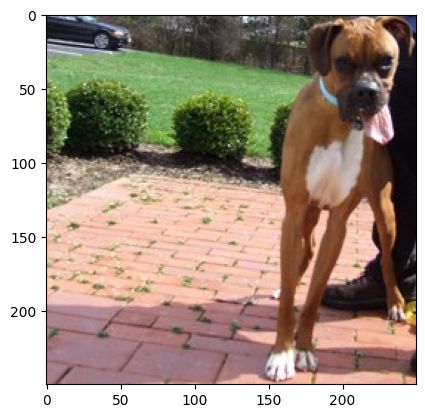

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/petimages_split/test/Dog/10030.jpg')
plt.imshow(img)

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    # Load the image with same size used in training
    img = image.load_img(img_path, target_size=(150, 150))

    # Convert to array and rescale
    img_array = image.img_to_array(img) / 255.0

    # Add batch dimension (model expects shape (1,150,150,3))
    img_array = np.expand_dims(img_array, axis=0)

    # Get prediction
    prediction = model.predict(img_array)

    # Class labels in training generator
    class_indices = {0: 'Cat', 1: 'Dog'}

    # Get predicted class index
    predicted_class = np.argmax(prediction[0])

    # Confidence score
    confidence = prediction[0][predicted_class] * 100

    return class_indices[predicted_class], confidence

# Example usage:
img_path = "/content/petimages_split/test/Dog/10030.jpg"
label, conf = predict_image(img_path, model_feature_extract)
print(f"Prediction: {label} ({conf:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: Dog (100.00% confidence)


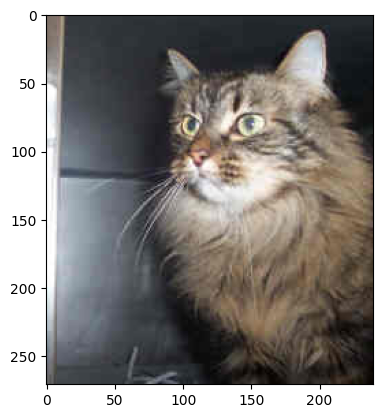

In [23]:
img2 = mpimg.imread('/content/petimages_split/test/Cat/10164.jpg')
plt.imshow(img2)

In [24]:
img_path = "/content/petimages_split/test/Cat/10164.jpg"
label, conf = predict_image(img_path, model_feature_extract)
print(f"Prediction: {label} ({conf:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: Cat (100.00% confidence)
